# Imports & general process functions

In [1]:
import os
import time
from functools import partial

import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import nevergrad as ng

from PIL import Image
from skimage.transform import resize
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from drawing import draw_imgs, maps_img
from turing import generate_pattern

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

if torch.cuda.is_available():
    device = torch.device('cuda')
    load_to_cpu = False
else:
    device = torch.device('cpu')
    load_to_cpu = True

In [3]:
mobilenet = models.mobilenet_v2(pretrained=True).to(device)
mobilenet.eval()
print('Success!')

Success!


In [4]:
vgg = models.vgg19(pretrained=True).to(device)
vgg.eval()
print('VGG success!')

VGG success!


In [5]:
inception = models.inception_v3(pretrained=True).to(device)
inception.eval()
print('Inception success!')

Inception success!


#### Set up the dataset

In [6]:
def get_custom_transform(img, pil=True, tensor=True):
    all_transforms = []
    
    if pil:
        crop_size = min(img.size)
        pil_transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(224),
        ])
        all_transforms.append(pil_transform)
    if tensor:
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        all_transforms.append(tensor_transform)

    full_transform = transforms.Compose(all_transforms)
    return full_transform

In [7]:
imagenet_path = '/workspace/raid/datasets/imagenet/val'

class AdversarialImageNet(Dataset):
    def __init__(
            self, imagenet_path, adv=None, tensor_transform=False, 
            adv_addition='original', adv_transform=None):
        self.imagenet_path = imagenet_path
        self.imagenet_data = torchvision.datasets.ImageFolder(self.imagenet_path)
        
        self.adv = adv
        if adv_addition not in ('original', 'resized'):
            raise ValueError('`adv_addition` must be either "original" or "resized"')
        self.adv_addition = adv_addition
        self.adv_transform = adv_transform
        if tensor_transform:
            self.tensor_transform = get_custom_transform(None, pil=False, tensor=True)
        else:
            self.tensor_transform = None
    
    def __len__(self):
        return len(self.imagenet_data)
    
    def __getitem__(self, idx):
        img, gt_class = self.imagenet_data[idx]
        pil_transform = get_custom_transform(img, pil=True, tensor=False)
        
        if self.adv is not None:
            if self.adv_addition == 'original':
                attack_img = add_attack(img, self.adv, self.adv_transform, final_transform=pil_transform)
            else:
                attack_img = add_attack(pil_transform(img), self.adv, self.adv_transform)
        else:
            attack_img = pil_transform(img)
        
        if self.tensor_transform is not None:
            return self.tensor_transform(attack_img), gt_class
        else:
            return attack_img, gt_class
            

In [8]:
import requests

# ImageNet class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
class_names = list(requests.get(LABELS_URL).json().values())
n_classes = len(class_names)

In [9]:
def forward(img, net, transform=None, batch=False, cpu_out=False):
    # perform transformation and store resizing info
    if not batch:
        if transform is not None:
            trans_img = transform(img).unsqueeze(0)
        else:
            trans_img = img.unsqueeze(0)
    else:
        trans_img = img
    
    # perform forward-pass
    trans_img = trans_img.to(device)
    if cpu_out:
        out_logits = net(trans_img).to('cpu')
    else:
        out_logits = net(trans_img)
        
    del trans_img
    torch.cuda.empty_cache()
    
    # decode the outputs
    return torch.softmax(out_logits, 1)

def print_class(out_scores):
    class_idx = torch.argmax(out_scores).item()
    print(f'Class: "{class_names[class_idx]}"')
    print(f'Score: {out_scores[0, class_idx].item():.3f}')

In [10]:
def attack_transform(adv, img):
    return resize(adv, img.size[::-1])

def add_attack(img, adv, attack_transform=None, final_transform=None):
    if attack_transform is not None:
        full_attack = attack_transform(adv, img)
    else:
        full_attack = adv
    attack_img = Image.fromarray(np.clip(img + full_attack.astype(np.int), 0, 255).astype(np.uint8), 'RGB')
    
    if final_transform is not None:
        return final_transform(attack_img)
    else:
        return attack_img
    
def find_attacks(optimizers, loss_fun):
    opt_loss_hists = {}
    opt_recommendations = {}
    for name, optim in optimizers.items():
        opt_loss_hist = []    

        for i in range(optim.budget):
            x = optim.ask()
            loss_val = loss_fun(*x.args, **x.kwargs)
            optim.tell(x, loss_val)
            
            #tmp_rec = optim.provide_recommendation()
            #opt_loss_hist.append(loss_fun(*tmp_rec.args, **tmp_rec.kwargs))
            opt_loss_hist.append(optim.current_bests['pessimistic'].mean)
            
            if i % 10 == 1:
                clear_output()
                plt.title(f'Loss history for {name}')
                plt.plot(opt_loss_hist)
                plt.show()
            del x
            del loss_val

        recommendation = optim.provide_recommendation()
        opt_recommendations[name] = recommendation
        opt_loss_hists[name] = opt_loss_hist
        print(f'Optimal loss for {name}: {opt_loss_hist[-1]}')
    return opt_loss_hists, opt_recommendations

In [11]:
# filenames of 224x224 random intialization true Turing patterns of various sizes
turing_names224 = os.listdir("turing_224_true/")

In [12]:
def tile(a, times, channel_axis=2):
    axes = set(range(a.ndim))
    axes.remove(channel_axis)
    return np.repeat(np.repeat(a, times, axis=axes.pop()), times, axis=axes.pop())

In [13]:
def pattern_sr_loss(pattern, adv_dataset, model=mobilenet, n_imgs=100):
    # use pattern as adversarial attack
    adv_dataset.adv = pattern
    indices = np.random.choice(range(len(adv_dataset)), n_imgs, replace=False)
    attacks = Subset(adv_dataset, indices)
    loader = DataLoader(attacks, batch_size=128, num_workers=8)

    # perform attacks
    gts = []
    attack_classes = []
    for batch, gt in tqdm(loader, desc='Attack in progress'):
        out = forward(batch, model, batch=True)
        gts.extend(gt.numpy().tolist())
        attack_classes.extend(out.argmax(axis=-1).cpu().detach().numpy().tolist())
        del out
        
    del loader
    del attacks

    # calculate success rate
    gts = np.array(gts)
    attack_classes = np.array(attack_classes)
    sr = (gts != attack_classes).sum() / len(gts)
    return 1 - sr

In [14]:
def get_init_maps(init_maps, init_multiplier, channel_axis=0, tile_init=True):
    if tile_init:
        return tile(np.sign(init_maps), init_multiplier, channel_axis=channel_axis)
    else:
        full_shape = np.array(init_maps.shape) * init_multiplier
        full_shape[channel_axis] /= init_multiplier
        return np.sign(resize(init_maps, full_shape))

In [27]:
def success_rate(gt_classes, outs):
    n = 0
    for gt_class, out in zip(gt_classes, outs):
        if out.argmax().item() != gt_class:
            n += 1
    return n / len(gt_classes)

In [ ]:
npy_prefix = 'npy_results'

# Turing patterns as attacks

## Independent patterns

#### MobileNet average attack performance

In [133]:
params = [tuple(map(int, turing_name.split('.')[0].split('_')[-2:])) for turing_name in turing_names224]

adv_imagenet = AdversarialImageNet(imagenet_path, adv=None, tensor_transform=True, 
                                   adv_addition='resized')
srs = []
for p, turing_name in zip(params, turing_names224):
    L1, L2 = p
    turing_pattern = np.load(f"turing_224_true/{turing_name}")
    
    sr = 1 - pattern_sr_loss(turing_pattern, adv_dataset, mobilenet, n_imgs=10000)
    srs.append(sr)
    print(f'{(L1, L2)}-pattern has SR: {sr}')
    
print(f'Average Turing SR: {np.array(srs).mean()}')


(7, 7)-pattern has SR: 0.5211



(3, 9)-pattern has SR: 0.4788



(1, 11)-pattern has SR: 0.5459



(1, 1)-pattern has SR: 0.45100000000000007



(7, 3)-pattern has SR: 0.5184



(3, 5)-pattern has SR: 0.5757



(1, 9)-pattern has SR: 0.5452



(3, 3)-pattern has SR: 0.6113



(3, 7)-pattern has SR: 0.4841



(11, 3)-pattern has SR: 0.5351



(9, 7)-pattern has SR: 0.49439999999999995



(9, 1)-pattern has SR: 0.6157



(5, 3)-pattern has SR: 0.5936



(5, 1)-pattern has SR: 0.5984



(7, 9)-pattern has SR: 0.44989999999999997



(9, 9)-pattern has SR: 0.4636



(3, 11)-pattern has SR: 0.47920000000000007



(11, 11)-pattern has SR: 0.5806



(5, 11)-pattern has SR: 0.4605



(1, 7)-pattern has SR: 0.5477



(7, 5)-pattern has SR: 0.5323



(7, 11)-pattern has SR: 0.45819999999999994



(11, 5)-pattern has SR: 0.5225



(9, 11)-pattern has SR: 0.4482999999999999



(3, 1)-pattern has SR: 0.5643



(9, 3)-pattern has SR: 0.5277



(5, 7)-pattern has SR: 0.49239999999999995



(11, 7)-pattern has SR: 0.4961



(1, 5)-pattern has SR: 0.5462



(11, 1)-pattern has SR: 0.606



(5, 5)-pattern has SR: 0.5746



(11, 9)-pattern has SR: 0.48560000000000003



(5, 9)-pattern has SR: 0.4627



(7, 1)-pattern has SR: 0.6026



(9, 5)-pattern has SR: 0.5135



(1, 3)-pattern has SR: 0.5459
Average Turing SR: 0.5258083333333334


#### VGG average attack performance

In [ ]:
params = [tuple(map(int, turing_name.split('.')[0].split('_')[-2:])) for turing_name in turing_names224]

adv_dataset = AdversarialImageNet(imagenet_path, adv=None, tensor_transform=True, 
                                   adv_addition='resized')
vgg_srs = []
for p, turing_name in zip(params, turing_names224):
    L1, L2 = p
    turing_pattern = np.load(f"turing_224_true/{turing_name}")
    
    sr = 1 - pattern_sr_loss(turing_pattern, adv_dataset, vgg, n_imgs=10000)
    vgg_srs.append(sr)
    print(f'{(L1, L2)}-pattern has SR: {sr}')
    
print(f'Average Turing SR: {np.array(vgg_srs).mean()}')

In [15]:
print(f'Average Turing SR: {np.array(vgg_srs).mean()}')

Average Turing SR: 0.5249444444444444


#### Inception average attack performance

In [57]:
params = [tuple(map(int, turing_name.split('.')[0].split('_')[-2:])) for turing_name in turing_names224]

adv_dataset = AdversarialImageNet(imagenet_path, adv=None, tensor_transform=True, 
                                   adv_addition='resized')
inc_srs = []
for p, turing_name in zip(params, turing_names224):
    L1, L2 = p
    turing_pattern = np.load(f"turing_224_true/{turing_name}")
    
    sr = 1 - pattern_sr_loss(turing_pattern, adv_dataset, inception, n_imgs=10000)
    inc_srs.append(sr)
    print(f'{(L1, L2)}-pattern has SR: {sr}')
    
print(f'Average Turing SR: {np.array(inc_srs).mean()}, max: {np.array(inc_srs).max()}')


(7, 7)-pattern has SR: 0.5113



(3, 9)-pattern has SR: 0.44199999999999995



(1, 11)-pattern has SR: 0.4264



(1, 1)-pattern has SR: 0.3771



(7, 3)-pattern has SR: 0.4888



(3, 5)-pattern has SR: 0.525



(1, 9)-pattern has SR: 0.42680000000000007



(3, 3)-pattern has SR: 0.5195



(3, 7)-pattern has SR: 0.473



(11, 3)-pattern has SR: 0.4595



(9, 7)-pattern has SR: 0.47540000000000004



(9, 1)-pattern has SR: 0.4555



(5, 3)-pattern has SR: 0.5245



(5, 1)-pattern has SR: 0.4393



(7, 9)-pattern has SR: 0.46320000000000006



(9, 9)-pattern has SR: 0.47009999999999996



(3, 11)-pattern has SR: 0.4337



(11, 11)-pattern has SR: 0.4487



(5, 11)-pattern has SR: 0.4252



(1, 7)-pattern has SR: 0.43320000000000003



(7, 5)-pattern has SR: 0.4952



(7, 11)-pattern has SR: 0.4356



(11, 5)-pattern has SR: 0.4636



(9, 11)-pattern has SR: 0.4226



(3, 1)-pattern has SR: 0.42680000000000007



(9, 3)-pattern has SR: 0.4731000000000001



(5, 7)-pattern has SR: 0.4928



(11, 7)-pattern has SR: 0.46730000000000005



(1, 5)-pattern has SR: 0.4328000000000001



(11, 1)-pattern has SR: 0.45009999999999994



(5, 5)-pattern has SR: 0.5262



(11, 9)-pattern has SR: 0.4569



(5, 9)-pattern has SR: 0.4444



(7, 1)-pattern has SR: 0.4368000000000001



(9, 5)-pattern has SR: 0.48



(1, 3)-pattern has SR: 0.4165
Average Turing SR: 0.45941388888888884, max: 0.5262


## Optimizing Turing pattern parameters with `nevergrad`

In [20]:
from turing import generate_pattern
import time

def turing_param_loss(L1, L2, init_maps, adv_dataset, model=mobilenet, 
                      turing_N=13, n_imgs=100, init_multiplier=3, tile_init=True):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    init_maps = get_init_maps(init_maps, init_multiplier, tile_init=tile_init)
    adv = generate_pattern(img_size, kernel_N=turing_N, kernel_L1=L1, kernel_L2=L2, init_maps=init_maps)
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [60]:
N = 13
L1 = ng.var.SoftmaxCategorical(range(1, N, 2))
L2 = ng.var.SoftmaxCategorical(range(1, N, 2))
init_map_shape = (3, 7, 7)
init_multiplier = 32
init_maps = ng.var.Array(*init_map_shape)

turing_instrum = ng.Instrumentation(L1, L2, init_maps)

In [61]:
adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

turing_sr_loss_fun = partial(turing_param_loss, model=inception, adv_dataset=adv_dataset, turing_N=N,
                             n_imgs=512, init_multiplier=init_multiplier, tile_init=False)
turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=250)}

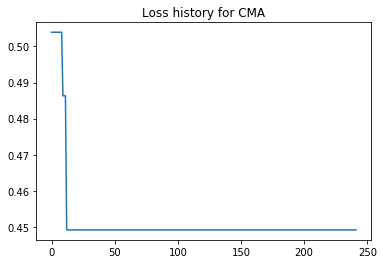


Optimal loss for CMA: 0.44921875
CPU times: user 1h 4min 13s, sys: 4min 17s, total: 1h 8min 30s
Wall time: 24min 7s


In [62]:
%%time
opt_loss_hists, opt_recommendations = find_attacks(turing_optimizers, loss_fun=turing_sr_loss_fun)

In [63]:
print(f"Final loss: {opt_loss_hists['CMA'][-1]}")

Final loss: 0.44921875


In [64]:
L1_opt, L2_opt, init_opt = opt_recommendations['CMA'].args
init_opt = get_init_maps(init_opt, init_multiplier, tile_init=False)

img_size = tuple(adv_dataset[0][0].shape[-2:])
pattern = generate_pattern(img_size, kernel_N=N, kernel_L1=L1_opt, 
                           kernel_L2=L2_opt, init_maps=init_opt)

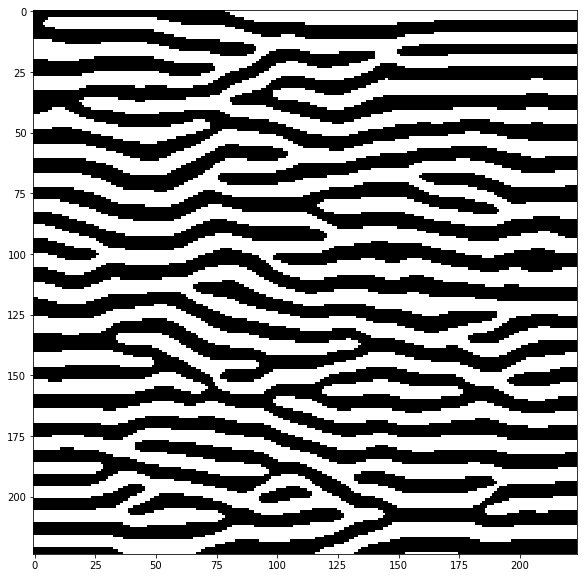

In [65]:
plt.figure(figsize=(10, 10))
plt.imshow(maps_img(pattern)) 

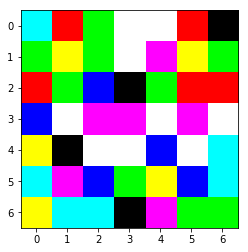

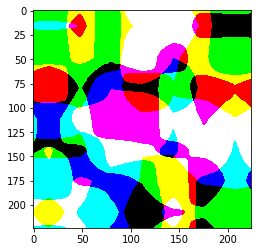

In [66]:
# draw resulting initialization map
init_opt_nomul = np.sign(opt_recommendations['CMA'].args[-1])
plt.imshow(maps_img(init_opt_nomul))
plt.show()
plt.imshow(maps_img(get_init_maps(opt_recommendations['CMA'].args[-1], init_multiplier, tile_init=False)))
plt.show()

In [68]:
final_sr = 1 - turing_param_loss(*opt_recommendations['CMA'].args, adv_dataset, model=inception,
                              turing_N=N, n_imgs=10000, init_multiplier=init_multiplier, tile_init=False)
print(f'Final pattern success rate: {final_sr}')


Final pattern success rate: 0.44300000000000006


In [ ]:
srs = []
for i in range(10):
    sr = 1 - turing_param_loss(*opt_recommendations['CMA'].args, adv_dataset, 
                                  turing_N=N, n_imgs=1000, init_multiplier=init_multiplier)
    srs.append(sr)
    print(sr)
srs = np.array(srs)
print(srs.mean())


0.547



0.567



0.57



0.545



0.552


## Optimizing Turing convolutional kernel & initialization with `nevergrad`

In [15]:
def turing_kernel_loss(kernel, init_maps, adv_dataset, model=mobilenet, n_imgs=100, init_multiplier=3):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    init_maps = get_init_maps(init_maps, init_multiplier)
    adv = generate_pattern(img_size, conv_kernel=kernel, init_maps=init_maps)
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [16]:
N = 13
turing_kernel = ng.var.Array(N, N)
init_map_shape = (3, 7, 7)
init_multiplier = 32
init_maps = ng.var.Array(*init_map_shape)

turing_instrum = ng.Instrumentation(turing_kernel, init_maps)

In [17]:
turing_instrum.dimension

316

In [25]:
adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

turing_sr_loss_fun = partial(turing_kernel_loss, adv_dataset=adv_dataset, model=mobilenet, n_imgs=512, init_multiplier=init_multiplier)
turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=250)}

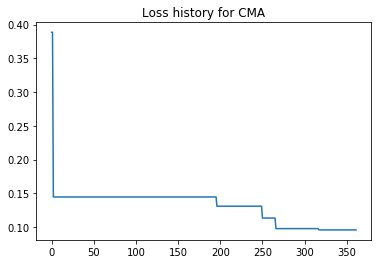

In [ ]:
%%time
opt_model_recs = []
opt_model_losses = []
model_srs = []
for model in [mobilenet, vgg, inception]:
    # optimize pattern
    adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

    turing_sr_loss_fun = partial(turing_kernel_loss, adv_dataset=adv_dataset, model=model, n_imgs=512, init_multiplier=init_multiplier)
    turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=500)}
    opt_loss_hists, opt_recommendations = find_attacks(turing_optimizers, loss_fun=turing_sr_loss_fun)
    opt_model_losses.append(opt_loss_hists)
    opt_model_recs.append(opt_recommendations)
    
    # generate pattern and attack
    kernel, init_opt = opt_recommendations['CMA'].args
    init_opt = get_init_maps(init_opt, init_multiplier)

    img_size = tuple(adv_dataset[0][0].shape[-2:])
    pattern = generate_pattern(img_size, conv_kernel=kernel, init_maps=init_opt)
    
    final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, model , n_imgs=10000)
    print(f'Final pattern success rate: {final_sr}')
    model_srs.append(final_sr)

In [35]:
model_srs

[0.9081, 0.7526, 0.5505]

In [28]:
kernel, init_opt = opt_recommendations['CMA'].args
init_opt = get_init_maps(init_opt, init_multiplier)

img_size = tuple(adv_dataset[0][0].shape[-2:])
pattern = generate_pattern(img_size, conv_kernel=kernel, init_maps=init_opt)

In [30]:
final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, mobilenet , n_imgs=10000)
print(f'Final pattern success rate: {final_sr}')


Final pattern success rate: 0.8553


## Turing filters without `init_map` optimization

In [16]:
def turing_kernel_noinit_loss(kernel, adv_dataset, model=mobilenet, n_imgs=100):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    adv = generate_pattern(img_size, conv_kernel=kernel)
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [53]:
N = 13
turing_kernel = ng.var.Array(N, N)
turing_instrum = ng.Instrumentation(turing_kernel)

adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

turing_sr_noinit_loss_fun = partial(turing_kernel_noinit_loss, adv_dataset=adv_dataset, model=vgg, n_imgs=512)
turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=250)}

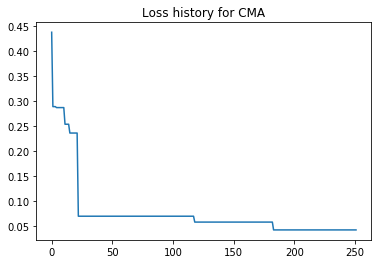

In [ ]:
%%time
# Test multiple models
opt_mopt_recommendations= []
opt_model_losses = []
model_srs = []
for model in [mobilenet, vgg, inception]:
    # optimize pattern
    adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

    turing_sr_noinit_loss_fun = partial(turing_kernel_noinit_loss, adv_dataset=adv_dataset, model=model, n_imgs=512)
    turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=500)}
    opt_loss_hists, opt_recommendations = find_attacks(turing_optimizers, loss_fun=turing_sr_noinit_loss_fun)
    opt_model_losses.append(opt_loss_hists)
    opt_model_recs.append(opt_recommendations)
    
    # generate pattern and attack
    kernel = opt_recommendations['CMA'].args[0]
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    
    final_srs = []
    for i in range(50):
        pattern = generate_pattern(img_size, conv_kernel=kernel)
        final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, model, n_imgs=10000)
        final_srs.append(final_sr)
    final_srs = np.array(final_srs)
    model_srs.append(final_srs)
model_srs = np.array(model_srs)

In [30]:
model_srs.mean(axis=1)

array([0.916082, 0.805246, 0.537466])

In [55]:
kernel = opt_recommendations['CMA'].args[0]
img_size = tuple(adv_dataset[0][0].shape[-2:])
pattern = generate_pattern(img_size, conv_kernel=kernel)

In [56]:
%%time
final_srs = []
for i in range(50):
    pattern = generate_pattern(img_size, conv_kernel=kernel)
    final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, vgg, n_imgs=10000)
    final_srs.append(final_sr)

final_srs = np.array(final_srs)
print(f'Final pattern success rate stats: {final_srs.mean(), final_srs.min(), final_srs.max()}')


Final pattern success rate stats: (0.7700920000000001, 0.759, 0.7793)
CPU times: user 8min 43s, sys: 4min 59s, total: 13min 43s
Wall time: 20min 33s


In [57]:
print(f'Final pattern success rate stats: {final_srs.mean(), final_srs.min(), final_srs.max()}')

Final pattern success rate stats: (0.7700920000000001, 0.759, 0.7793)


### Different channel mixing approaches

#### 2D filter on completely separate channels

In [15]:
# 2D filter on completely separate channels
N = 13
turing_kernel_2d = ng.var.Array(N, N)
turing_instrum_2d = ng.Instrumentation(turing_kernel_2d)

adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

def turing_kernel_2d_loss(kernel, adv_dataset, model=mobilenet, n_imgs=100):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    adv = generate_pattern(img_size, conv_kernel=kernel, separate_channels=True, kernel_type='2D')
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [18]:
turing_sr_noinit_2d_loss_fun = partial(turing_kernel_2d_loss, adv_dataset=adv_dataset, model=mobilenet, n_imgs=512)
optimizers_2d = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum_2d, budget=250)}

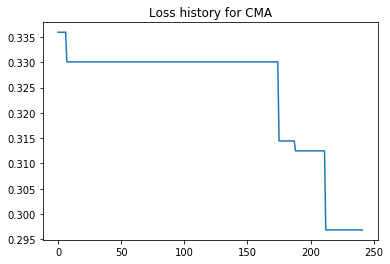


Optimal loss for CMA: 0.296875
CPU times: user 18min 28s, sys: 3min 57s, total: 22min 25s
Wall time: 21min 2s


In [25]:
%%time
opt_loss_hists, opt_recommendations = find_attacks(optimizers_2d, loss_fun=turing_sr_noinit_2d_loss_fun)

In [26]:
kernel_2d = opt_recommendations['CMA'].args[0]
img_size = tuple(adv_dataset[0][0].shape[-2:])

final_srs = []
for i in range(50):
    pattern = generate_pattern(img_size, conv_kernel=kernel_2d, separate_channels=True, kernel_type='2D')
    final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, mobilenet, n_imgs=10000)
    final_srs.append(final_sr)
final_srs = np.array(final_srs)

In [28]:
print(final_srs.mean())

0.6184339999999999


#### 3D-filter

In [30]:
# 3D-filter on completely separate channels
turing_kernel_3d = ng.var.Array(N, N, 3)
turing_instrum_3d = ng.Instrumentation(turing_kernel_3d)

def turing_kernel_3d_loss(kernel, adv_dataset, model=mobilenet, n_imgs=100):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    adv = generate_pattern(img_size, conv_kernel=kernel, separate_channels=True, kernel_type='3D')
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [31]:
turing_sr_noinit_3d_loss_fun = partial(turing_kernel_3d_loss, adv_dataset=adv_dataset, model=mobilenet, n_imgs=512)
optimizers_3d = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum_3d, budget=250)}

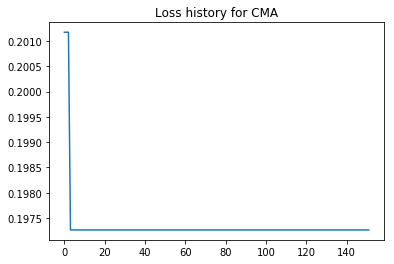

In [ ]:
%%time
opt_loss_hists, opt_recommendations = find_attacks(optimizers_3d, loss_fun=turing_sr_noinit_3d_loss_fun)

In [ ]:
kernel_3d = opt_recommendations['CMA'].args[0]
img_size = tuple(adv_dataset[0][0].shape[-2:])

final_srs_3d = []
for i in range(50):
    pattern = generate_pattern(img_size, conv_kernel=kernel_3d, separate_channels=True, kernel_type='3D')
    final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, mobilenet, n_imgs=10000)
    final_srs_3d.append(final_sr)
final_srs_3d = np.array(final_srs_3d)

#### Pointwise: 3 2D-filters then 1x1 convolution (3x3 matrix)


In [54]:
# 3 2D-filters then 1x1 convolution (3x3 matrix)opt_loss_hists
turing_kernels = ng.var.Array(N, N, 3)
turing_pointwise = ng.var.Array(3, 3)
turing_instrum_pw = ng.Instrumentation(turing_kernels, turing_pointwise)

def turing_kernel_pw_loss(kernels, pointwise, adv_dataset, model=mobilenet, n_imgs=100):
    # generate Turing pattern
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    adv = generate_pattern(img_size, conv_kernel=kernels, separate_channels=True, 
                           kernel_type='pointwise', pointwise_kernel=pointwise)
    return pattern_sr_loss(adv, adv_dataset, model=model, n_imgs=n_imgs)

In [59]:
turing_sr_noinit_pw_loss_fun = partial(turing_kernel_pw_loss, adv_dataset=adv_dataset, model=inception, n_imgs=512)
optimizers_pw = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum_pw, budget=250)}

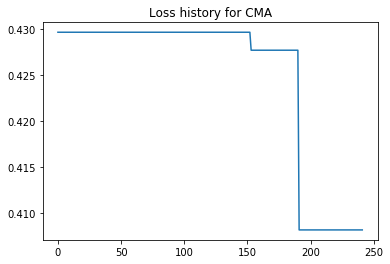


Optimal loss for CMA: 0.408203125
CPU times: user 18min 23s, sys: 4min 8s, total: 22min 31s
Wall time: 19min 2s


In [65]:
%%time
opt_loss_hists, opt_recommendations = find_attacks(optimizers_pw, loss_fun=turing_sr_noinit_pw_loss_fun)

In [66]:
kernels_pw, pointwise = opt_recommendations['CMA'].args
img_size = tuple(adv_dataset[0][0].shape[-2:])

final_srs_pw = []
for i in range(50):
    pattern = generate_pattern(img_size, conv_kernel=kernels_pw, separate_channels=True, 
                               kernel_type='pointwise', pointwise_kernel=pointwise)
    final_sr = 1 - pattern_sr_loss(pattern, adv_dataset, inception, n_imgs=10000)
    final_srs_pw.append(final_sr)
final_srs_pw = np.array(final_srs_pw)

In [71]:
print(final_srs_pw.mean())

0.5348780000000001


## Turing filters for ranging filter size

### With initialization optimization

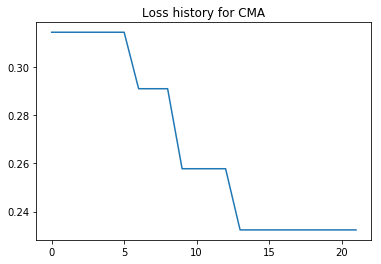

In [ ]:
%%time 
N_range = range(3, 25)

loss_hists = []
recs = []

for N in tqdm(N_range):
    turing_kernel = ng.var.Array(N, N)
    init_map_shape = (3, 7, 7)
    init_multiplier = 32
    init_maps = ng.var.Array(*init_map_shape)

    turing_instrum = ng.Instrumentation(turing_kernel, init_maps)
    adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                      adv_addition='resized')
    turing_sr_loss_fun = partial(turing_kernel_loss, adv_dataset=adv_dataset, model=mobilenet, 
                                        n_imgs=512, init_multiplier=init_multiplier)
    turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=250)}

    opt_loss_hists, opt_recommendations = find_attacks(turing_optimizers, loss_fun=turing_sr_loss_fun)
    loss_hists.append(opt_loss_hists)
    recs.append(opt_recommendations)

In [18]:
%%time 

adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')
srs = []
for rec in recs:
    kernel, init_opt = rec['CMA'].args
    init_opt = get_init_maps(init_opt, init_multiplier)
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    pattern = generate_pattern(img_size, conv_kernel=kernel, init_maps=init_opt)

    rec_srs = []
    for i in range(3):
        sr = 1 - pattern_sr_loss(pattern, adv_dataset, mobilenet, n_imgs=10000)
        #print(f'Final pattern success rate: {final_sr}')
        rec_srs.append(sr)
    rec_srs = np.array(rec_srs)
    srs.append(rec_srs)
srs = np.array(srs)


CPU times: user 6min 17s, sys: 3min 13s, total: 9min 30s
Wall time: 18min 23s


In [19]:
srs.mean(axis=1)

array([0.72413333, 0.72926667, 0.97103333, 0.92786667, 0.88606667,
       0.77156667, 0.8979    , 0.86996667, 0.88276667, 0.94393333,
       0.85563333, 0.92526667, 0.89816667, 0.91343333, 0.82923333,
       0.83756667, 0.89106667, 0.8398    , 0.7793    , 0.91136667,
       0.77523333, 0.86616667])

In [2]:
N_range = range(3, 25)

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

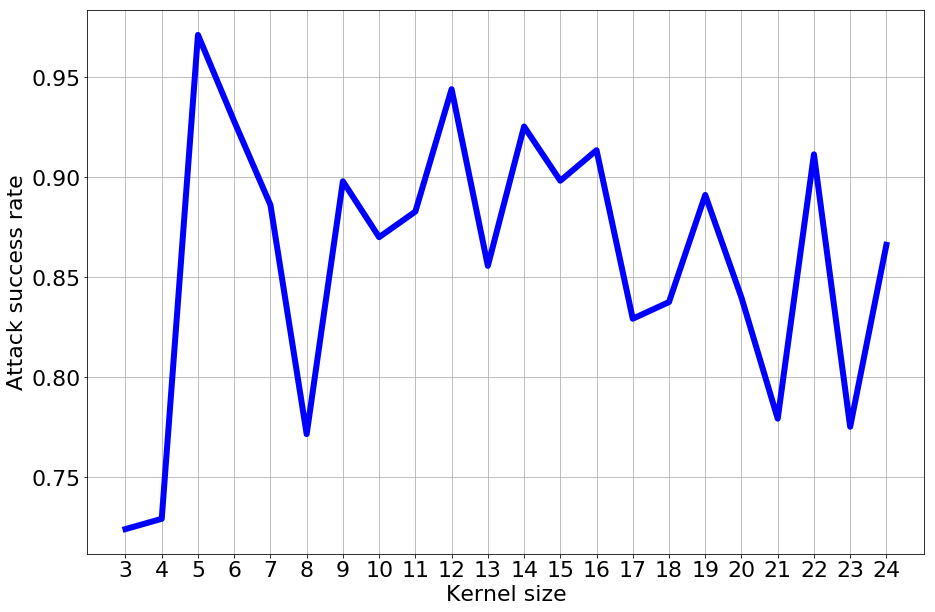

In [18]:
plt.figure(figsize=(15,10))
plt.plot(N_range, srs.mean(axis=1), c='blue', linewidth=6)
#plt.fill_between(N_range, srs.min(axis=1), srs.max(axis=1), color='green', alpha=0.2)
#plt.plot(N_range, noinit_srs.min(axis=1), c='red', linestyle=':', linewidth=2)
#plt.plot(N_range, noinit_srs.max(axis=1), c='red', linestyle=':', linewidth=2)

plt.xticks(N_range)
#plt.title('Only optimizing filter')
plt.xlabel('Kernel size')
plt.ylabel('Attack success rate')
plt.grid()
plt.show()

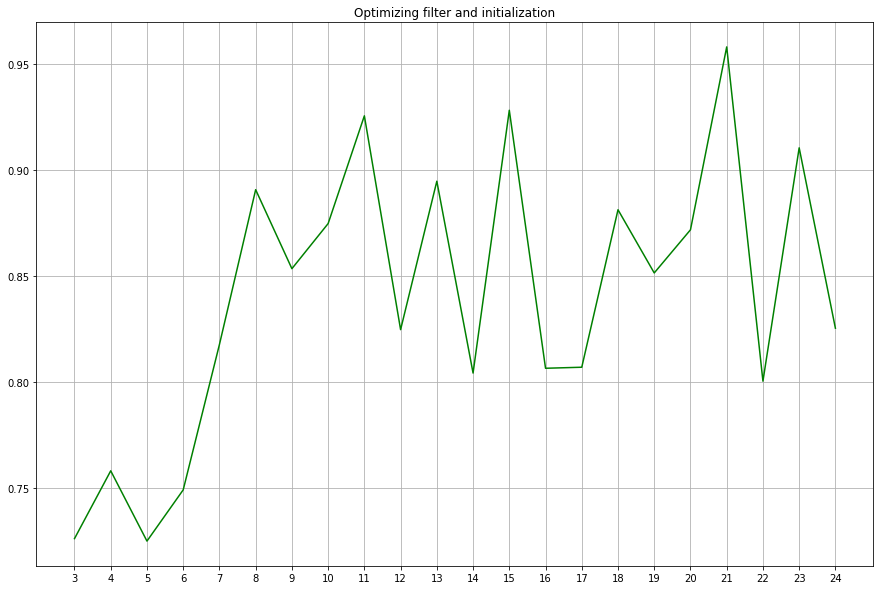

In [39]:
plt.figure(figsize=(15,10))
plt.plot(N_range, srs.mean(axis=1), c='green')
#plt.plot(N_range, srs.min(axis=1), c='red')
#plt.plot(N_range, srs.max(axis=1), c='red')

plt.xticks(N_range)
plt.title('Optimizing filter and initialization')
plt.grid()
plt.show()

### Without initialization optimization

In [18]:
N_range = range(3, 25)

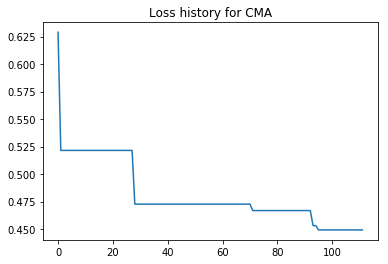

In [ ]:
%%time 


noinit_loss_hists = []
noinit_recs = []

for N in tqdm(N_range):
    turing_kernel = ng.var.Array(N, N)
    turing_instrum = ng.Instrumentation(turing_kernel)
    adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                      adv_addition='resized')

    turing_sr_noinit_loss_fun = partial(turing_kernel_noinit_loss, adv_dataset=adv_dataset, model=inception, n_imgs=512)
    turing_optimizers = {'CMA': ng.optimizers.CMA(instrumentation=turing_instrum, budget=250)}

    opt_loss_hists, opt_recommendations = find_attacks(turing_optimizers, loss_fun=turing_sr_noinit_loss_fun)
    noinit_loss_hists.append(opt_loss_hists)
    noinit_recs.append(opt_recommendations)
    
noinit_recs = np.array(noinit_recs)

In [ ]:
%%time 

adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')
noinit_srs = []
for rec in noinit_recs:
    kernel = rec['CMA'].args[0]
    rec_srs = []
    for i in range(10):
        pattern = generate_pattern(img_size, conv_kernel=kernel)
        sr = 1 - pattern_sr_loss(pattern, adv_dataset, mobilenet, n_imgs=10000)
        rec_srs.append(sr)
    rec_srs = np.array(rec_srs)
    noinit_srs.append(rec_srs)
noinit_srs = np.array(noinit_srs)

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

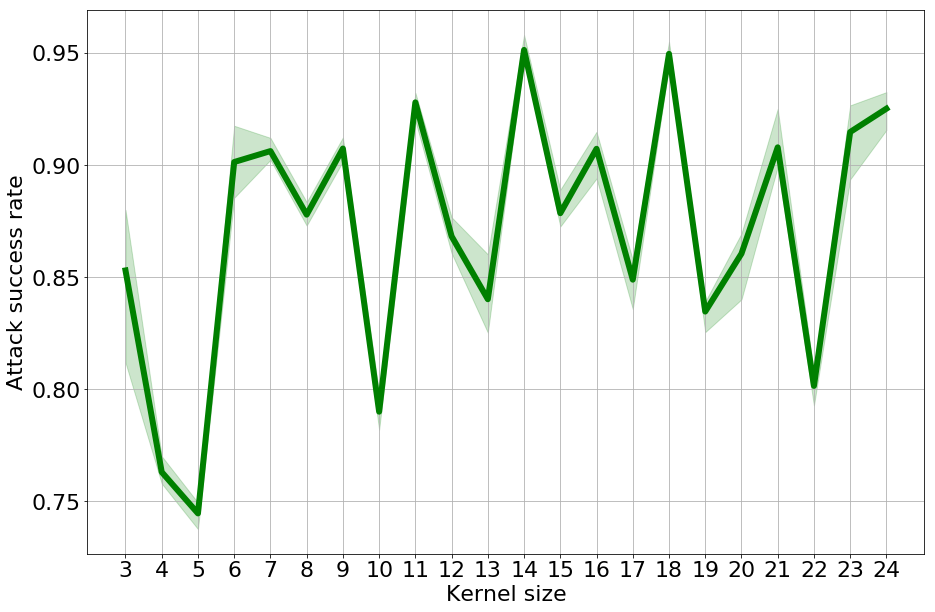

In [17]:
plt.figure(figsize=(15,10))
#plt.plot(N_range, srs.mean(axis=1), c='blue', linewidth=6, label='with init')
plt.plot(N_range, noinit_srs.mean(axis=1), c='green', linewidth=6, label='w/o init')
plt.fill_between(N_range, noinit_srs.min(axis=1), noinit_srs.max(axis=1), color='green', alpha=0.2)
#plt.plot(N_range, noinit_srs.min(axis=1), c='red', linestyle=':', linewidth=2)
#plt.plot(N_range, noinit_srs.max(axis=1), c='red', linestyle=':', linewidth=2)

plt.xticks(N_range)
#plt.title('Only optimizing filter')
plt.xlabel('Kernel size')
plt.ylabel('Attack success rate')
plt.grid()
#plt.legend()
plt.show()

# Transferability of attacks

### Random Turing 

In [23]:
# True Turing
true_patterns = os.listdir('turing_224_true/')
#pattern_indices = np.random.choice(range(len(true_patterns)), 15, replace=False)

random_srs = []
#for i in pattern_indices:
for i in range(len(true_patterns)):
    pattern = np.load(f'turing_224_true/{true_patterns[i]}')
    patterns = [pattern] * 3

    random_srs.append(attack_models(patterns, models, adv_dataset, pattern_names, model_names))


            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5291  0.5251      0.4983
VGG-19           0.5193  0.5187       0.507
InceptionV3      0.5263  0.5233       0.497



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4771  0.4566       0.437
VGG-19           0.4831  0.4619      0.4404
InceptionV3      0.4754  0.4618      0.4365



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5444  0.5581      0.4262
VGG-19           0.5432  0.5563      0.4342
InceptionV3      0.5379  0.5519      0.4274



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4519  0.4884      0.3804
VGG-19           0.4454  0.4888      0.3714
InceptionV3      0.4623  0.4894      0.3739



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5275  0.5046      0.4868
VGG-19           0.5225  0.5095      0.4841
InceptionV3      0.5243  0.4961      0.4918



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5795  0.5582      0.5219
VGG-19           0.5748  0.5633       0.521
InceptionV3      0.5752  0.5603       0.523



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5411  0.5575      0.4362
VGG-19           0.5488  0.5658      0.4279
InceptionV3      0.5466  0.5622      0.4309



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.6173  0.6124       0.524
VGG-19           0.6182  0.5994      0.5292
InceptionV3      0.6143  0.6093      0.5331



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4936  0.4762      0.4762
VGG-19           0.4907  0.4765      0.4784
InceptionV3       0.487  0.4805      0.4667



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5288  0.5015      0.4713
VGG-19            0.538  0.5128      0.4653
InceptionV3      0.5304  0.5094      0.4596



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5054  0.4775      0.4782
VGG-19            0.494  0.4804      0.4788
InceptionV3      0.4906  0.4858      0.4729



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.6197  0.6416      0.4554
VGG-19           0.6147  0.6349        0.46
InceptionV3      0.6115  0.6385       0.455



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5957  0.5584      0.5318
VGG-19           0.5929  0.5577      0.5302
InceptionV3      0.5914  0.5538      0.5268



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.6066  0.6134      0.4371
VGG-19           0.5994  0.6168       0.447
InceptionV3      0.6046  0.6168      0.4396



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4535  0.4556      0.4505
VGG-19           0.4609  0.4547      0.4609
InceptionV3      0.4563  0.4568      0.4594



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2       0.465  0.4785      0.4741
VGG-19           0.4641  0.4854       0.467
InceptionV3      0.4583  0.4786      0.4713



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4809  0.4714      0.4289
VGG-19           0.4918  0.4654      0.4376
InceptionV3      0.4827  0.4654      0.4318



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5794  0.6265      0.4424
VGG-19           0.5843  0.6298      0.4511
InceptionV3      0.5818  0.6319      0.4577



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4622  0.4477      0.4357
VGG-19           0.4633  0.4482      0.4394
InceptionV3       0.466  0.4475      0.4331



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5432  0.5502      0.4244
VGG-19           0.5408  0.5595      0.4293
InceptionV3      0.5424  0.5631      0.4247



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5355  0.5171      0.5048
VGG-19           0.5325  0.5099      0.4995
InceptionV3       0.534  0.5196      0.5057



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4711  0.4569      0.4331
VGG-19           0.4579  0.4475      0.4353
InceptionV3      0.4572  0.4481      0.4232



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5169  0.4938      0.4594
VGG-19            0.522  0.4875      0.4565
InceptionV3      0.5193  0.4977      0.4625



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4452  0.4332      0.4209
VGG-19           0.4409  0.4431      0.4269
InceptionV3      0.4376  0.4359      0.4266



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5556  0.5871      0.4249
VGG-19           0.5654  0.5811      0.4298
InceptionV3      0.5669   0.585       0.426



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5289  0.4977      0.4725
VGG-19           0.5263   0.501      0.4732
InceptionV3      0.5206  0.5102      0.4775



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5056  0.5072      0.4927
VGG-19           0.4959  0.5011       0.486
InceptionV3      0.4998  0.5022      0.4923



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5032  0.4833      0.4512
VGG-19           0.5067  0.4842      0.4641
InceptionV3      0.4996  0.4834      0.4629



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5417  0.5642      0.4342
VGG-19           0.5409  0.5586      0.4302
InceptionV3      0.5435  0.5644      0.4346



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.6069  0.6309      0.4565
VGG-19           0.6047  0.6379      0.4447
InceptionV3      0.6037  0.6319      0.4538



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5859  0.5689       0.532
VGG-19           0.5871  0.5693      0.5247
InceptionV3      0.5894  0.5623      0.5287



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4895  0.4688      0.4552
VGG-19           0.4915  0.4755      0.4606
InceptionV3      0.4912  0.4757      0.4615



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.4569  0.4554        0.44
VGG-19           0.4676  0.4568      0.4499
InceptionV3      0.4576  0.4552      0.4514



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.6001   0.626      0.4485
VGG-19           0.5987  0.6179       0.443
InceptionV3      0.6067  0.6198      0.4531



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5111  0.4872      0.4712
VGG-19           0.5249  0.5018      0.4768
InceptionV3      0.5169  0.5013       0.478



            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5526  0.5539      0.4236
VGG-19           0.5619  0.5587      0.4257
InceptionV3      0.5531  0.5547      0.4241


In [63]:
(sum(random_srs) / len(random_srs)) * 100

,MobileNetV2,VGG-19,InceptionV3
MobileNetV2,52.7913,52.7713,45.4727
VGG-19,52.9353,52.566,45.322
InceptionV3,52.976,52.5587,45.5553


### True Turing 

In [33]:
# True Turing
patterns = [np.load(f'{npy_prefix}/turing_true_mobilenet_250_50.npy'),
            np.load(f'{npy_prefix}/turing_true_vgg_250_53.npy'),
            np.load(f'{npy_prefix}/turing_true_inception_250_45.npy'),
           ]

attack_srs = attack_models(patterns, models, adv_dataset, pattern_names, model_names)


            MobileNetV2  VGG-19 InceptionV3
MobileNetV2       0.505  0.5067      0.4769
VGG-19           0.5543  0.5543      0.4504
InceptionV3      0.5003  0.4866       0.462


In [40]:
# True Turing
patterns = [np.load(f'{npy_prefix}/turing_true_mobilenet_500_56.npy'),
            np.load(f'{npy_prefix}/turing_true_vgg_500_49.npy'),
            np.load(f'{npy_prefix}/turing_true_inception_500_47.npy'),
           ]

attack_srs500 = attack_models(patterns, models, adv_dataset, pattern_names, model_names)


            MobileNetV2  VGG-19 InceptionV3
MobileNetV2      0.5615  0.5696      0.4516
VGG-19           0.5049  0.5006      0.4998
InceptionV3      0.4955  0.4876      0.4718


## Optimized with initialization

In [59]:
def attack_models(patterns, models, adv_dataset, pattern_names=None, model_names=None, n_imgs=10000):
    if pattern_names is None:
        pattern_names = range(len(patterns))
    if model_names is None:
        model_names = range(len(models))
        
    attack_srs = pd.DataFrame(index=pattern_names, columns=model_names)
    for pattern, pattern_name in zip(patterns, pattern_names):
        for model, model_name in zip(models, model_names):
            attack_srs.loc[pattern_name, model_name] = 1 - pattern_sr_loss(pattern, adv_dataset, model, n_imgs=n_imgs)
    print(attack_srs)
    return attack_srs

def generate_from_kernels(kernels, img_size, init_maps=None, n_per_kernel=1):
    patterns = []
    for kernel in kernels:
        for i in range(n_per_kernel):
            pattern = generate_pattern(img_size, init_maps=init_maps, conv_kernel=kernel)
            patterns.append(pattern)
    return patterns

In [ ]:
adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

patterns250 = [np.load(f'{npy_prefix}/turing_filter_pattern_mobilenet_85_250.npy'),
               np.load(f'{npy_prefix}/turing_filter_pattern_vgg_79_250.npy'),
               np.load(f'{npy_prefix}/turing_filter_pattern_inception_52_250.npy')]
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']
pattern_names = model_names
attack_res250 = attack_models(patterns250, models, adv_dataset, pattern_names, model_names)

In [ ]:
attack_res250

In [ ]:
patterns500 = [np.load(f'{npy_prefix}/turing_filter_pattern_mobilenet_91_500.npy'),
               np.load(f'{npy_prefix}/turing_filter_pattern_vgg_75_500.npy'),
               np.load(f'{npy_prefix}/turing_filter_pattern_inception_55_500.npy')]
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']
pattern_names = model_names
attack_res500 = attack_models(patterns500, models, adv_dataset, pattern_names, model_names)

In [ ]:
attack_res500

## Optimized without init

In [25]:
def attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=3, 
                         separate_channels=False, kernel_type='2D',
                         kernel_names=None, model_names=None, n_imgs=10000):
    if kernel_names is None:
        kernel_names = range(len(kernel_files))
    if model_names is None:
        model_names = range(len(models))
    
    img_size = tuple(adv_dataset[0][0].shape[-2:])
    attack_srs = pd.DataFrame(index=kernel_names, columns=model_names)
    full_attack_srs = []
    for kernel_file, kernel_name in zip(kernel_files, kernel_names):
        # load pattern kernel
        if kernel_type == 'pointwise':
            kernel = np.load(kernel_file[0])
            pointwise = np.load(kernel_file[1])
        else:
            kernel = np.load(kernel_file)
            pointwise = None
        
        # average result across several initializations
        kernel_srs = []
        for i in range(n_per_kernel):
            pattern = generate_pattern(img_size, conv_kernel=kernel, separate_channels=separate_channels, 
                                        kernel_type=kernel_type, pointwise_kernel=pointwise)
            pattern_srs = []
            for model in models:
                pattern_srs.append(1 - pattern_sr_loss(pattern, adv_dataset, model, n_imgs=n_imgs))
            kernel_srs.append(pattern_srs)
        kernel_srs = np.array(kernel_srs)
        full_attack_srs.append(kernel_srs)
        attack_srs.loc[kernel_name] = kernel_srs.mean(axis=0)
                
    full_attack_srs = np.array(full_attack_srs)
    print(attack_srs)
    return attack_srs, full_attack_srs

In [16]:
adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

In [17]:
img_size = tuple(adv_dataset[0][0].shape[-2:])

### Summation mixing 

In [35]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_kernel_mobilenet_94_500.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_vgg_77_500.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_inception_53_500.npy',
                ]
kernel_names = ['OG MobileNet', 'OG VGG', 'OG Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

attack_srs_og, stds_og = attack_models_noinit(kernel_files, models, adv_dataset, std=True,
                                                  n_per_kernel=50, separate_channels=False,
                                                  kernel_names=kernel_names, model_names=model_names)


             MobileNetV2    VGG-19 InceptionV3
OG MobileNet    0.945616  0.577136    0.350438
OG VGG          0.731824  0.775874    0.430216
OG Inception    0.638822  0.644628    0.532082


In [113]:
attack_srs_og * 100

,MobileNetV2,VGG-19,InceptionV3
OG MobileNet,94.467,57.685,35.168
OG VGG,73.213,77.611,42.97
OG Inception,63.859,64.507,53.229


In [ ]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_kernel_mobilenet_91_250.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_vgg_77_250.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_inception_53_250.npy',
                ]
kernel_names = ['OG MobileNet', 'OG VGG', 'OG Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

attack_srs_og250 = attack_models_noinit(kernel_files, models, adv_dataset, 
                                                  n_per_kernel=50, separate_channels=False,
                                                  kernel_names=kernel_names, model_names=model_names)

In [114]:
attack_srs_og250 * 100

,MobileNetV2,VGG-19,InceptionV3
OG MobileNet,91.6726,61.4032,35.0506
OG VGG,75.238,76.9448,44.013
OG Inception,60.2998,71.8066,53.7154


### 2D-filter with independent channels

In [21]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_2d_mobilenet_63_250.npy',
                f'{npy_prefix}/turing_filter_noinit_2d_vgg_60_250.npy',
                f'{npy_prefix}/turing_filter_noinit_2d_mobilenet_63_250.npy',
               ]
kernel_names = ['2D MobileNet', '2D VGG', '2D Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

srs_2d_250 = attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=50, 
                                  separate_channels=True, kernel_type='2D', 
                                  kernel_names=kernel_names, model_names=model_names)


             MobileNetV2    VGG-19 InceptionV3
2D MobileNet    0.636588   0.61649    0.441852
2D VGG          0.621162  0.606658    0.478396
2D Inception    0.634186  0.614714    0.438224


In [25]:
srs_2d_250 * 100

,MobileNetV2,VGG-19,InceptionV3
2D MobileNet,63.6588,61.649,44.1852
2D VGG,62.1162,60.6658,47.8396
2D Inception,63.4186,61.4714,43.8224


In [22]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_2d_mobilenet_61_500.npy',
                f'{npy_prefix}/turing_filter_noinit_2d_vgg_60_500.npy',
                f'{npy_prefix}/turing_filter_noinit_2d_inception_47_500.npy',
               ]
kernel_names = ['2D MobileNet', '2D VGG', '2D Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

srs_2d_500 = attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=50, 
                                  separate_channels=True, kernel_type='2D', 
                                  kernel_names=kernel_names, model_names=model_names)


             MobileNetV2    VGG-19 InceptionV3
2D MobileNet    0.608744  0.450024     0.37486
2D VGG          0.619944   0.60736     0.47759
2D Inception     0.53217  0.545382    0.474462


In [26]:
srs_2d_500 * 100

,MobileNetV2,VGG-19,InceptionV3
2D MobileNet,60.8744,45.0024,37.486
2D VGG,61.9944,60.736,47.759
2D Inception,53.217,54.5382,47.4462


### 3D-filter

In [26]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_3d_mobilenet_78_250.npy',
                f'{npy_prefix}/turing_filter_noinit_3d_vgg_78_250.npy',
                f'{npy_prefix}/turing_filter_noinit_3d_inception_46_250.npy',
               ]
kernel_names = ['3D MobileNet', '3D VGG', '3D Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

srs_3d_250 = attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=50, 
                                  separate_channels=True, kernel_type='3D', 
                                  kernel_names=kernel_names, model_names=model_names)


             MobileNetV2    VGG-19 InceptionV3
3D MobileNet    0.781534  0.672068    0.453378
3D VGG          0.763904  0.780564    0.435886
3D Inception     0.69007  0.726204    0.460034


In [27]:
srs_3d_250 * 100

,MobileNetV2,VGG-19,InceptionV3
3D MobileNet,78.1534,67.2068,45.3378
3D VGG,76.3904,78.0564,43.5886
3D Inception,69.007,72.6204,46.0034


In [30]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_3d_mobilenet_81_500.npy',
                f'{npy_prefix}/turing_filter_noinit_3d_vgg_78_500.npy',
                f'{npy_prefix}/turing_filter_noinit_3d_inception_51_500.npy',
               ]
kernel_names = ['3D MobileNet', '3D VGG', '3D Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

srs_3d_500 = attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=50, 
                                  separate_channels=True, kernel_type='3D', 
                                  kernel_names=kernel_names, model_names=model_names)


             MobileNetV2    VGG-19 InceptionV3
3D MobileNet    0.819666   0.68302    0.482372
3D VGG          0.761546  0.788688     0.43834
3D Inception     0.61355  0.616164     0.51306


### Pointwise mixing

In [109]:
kernel_files = [(f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_250.npy', f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_p_250.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_vgg_76_250.npy', f'{npy_prefix}/turing_filter_noinit_pw_vgg_76_p_250.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_inception_51_250.npy', f'{npy_prefix}/turing_filter_noinit_pw_inception_51_p_250.npy'),
                ]
kernel_names = ['PW MobileNet', 'PW VGG', 'PW Inception']
models = [mobilenet, vgg, inception]
model_names = ['MobileNetV2', 'VGG-19', 'InceptionV3']

attack_srs_pw = attack_models_noinit(kernel_files, models, adv_dataset, n_per_kernel=10, 
                                     separate_channels=True, kernel_type='pointwise', 
                                     kernel_names=kernel_names, model_names=model_names)

/workspace/turing.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif channel_mixing == '3D':



             MobileNetV2   VGG-19 InceptionV3
PW MobileNet     0.94377  0.57265     0.34934
PW VGG           0.75778  0.76598     0.43992
PW Inception     0.57462  0.63689     0.51811


In [110]:
print(attack_srs_pw * 100 )

             MobileNetV2  VGG-19 InceptionV3
PW MobileNet      94.377  57.265      34.934
PW VGG            75.778  76.598      43.992
PW Inception      57.462  63.689      51.811


# DFT patterns

### Generate DFT patterns and calculate their SRs

In [37]:
from turing_dft import DFT_matrix, df, new_dft_patterns

In [25]:
adv_dataset = AdversarialImageNet(imagenet_path, tensor_transform=True, 
                                  adv_addition='resized')

img_size = tuple(adv_dataset[0][0].shape[-2:])

In [44]:
import glob

In [18]:
dft_srs = []
for model, model_name in zip(models, model_names):
    model_srs = []
    for i in tqdm(range(50)):
        pat_name = glob.glob(f'{model_name}_*_{i}.npy')[0]
        sr_og = float(pat_name.split('_')[-2])
        pattern = np.load(pat_name)
        
        p1, p2 = new_dft_patterns(pattern)
        
        sr_p1 = 1 - pattern_sr_loss(p1, adv_dataset, model, n_imgs=10000)
        sr_p2 = 1 - pattern_sr_loss(p2, adv_dataset, model, n_imgs=10000)
        model_srs.append([sr_og, sr_p1, sr_p2])
    dft_srs.append(model_srs)
dft_srs = np.array(dft_srs)

In [22]:
dft_srs.mean(axis=1)

array([[0.945106, 0.949494, 0.949734],
       [0.77534 , 0.78011 , 0.779652],
       [0.53116 , 0.506134, 0.51014 ]])

### Generate PW DFT patterns and their SRs

In [47]:
kernel_files = [(f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_p_500.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_vgg_77_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_vgg_77_p_500.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_inception_53_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_inception_53_p_500.npy'),
                ]

patterns = generate_patterns_noinit(kernel_files, img_size, n_per_kernel=50,
                                    separate_channels=True, kernel_type='pointwise')

In [48]:
# separate per model patterns
pats = [patterns[:50], patterns[50:100], patterns[100:]]
patterns = pats

In [37]:
dft_pw_srs = []
for model, pats in zip(models, patterns):
    model_srs = []
    for pattern in pats:
        sr_og = 1 - pattern_sr_loss(pattern, adv_dataset, model, n_imgs=10000)
        p1, p2 = new_dft_patterns(pattern)
        
        sr_p1 = 1 - pattern_sr_loss(p1, adv_dataset, model, n_imgs=10000)
        sr_p2 = 1 - pattern_sr_loss(p2, adv_dataset, model, n_imgs=10000)
        model_srs.append([sr_og, sr_p1, sr_p2])
    dft_pw_srs.append(model_srs)
dft_pw_srs = np.array(dft_pw_srs)

In [40]:
dft_pw_srs.mean(axis=1) * 100

array([[94.5822, 95.1714, 95.1572],
       [78.059 , 77.6608, 77.9554],
       [53.3414, 53.6128, 53.4834]])

### Draw the original pattern vs two DFT modifications

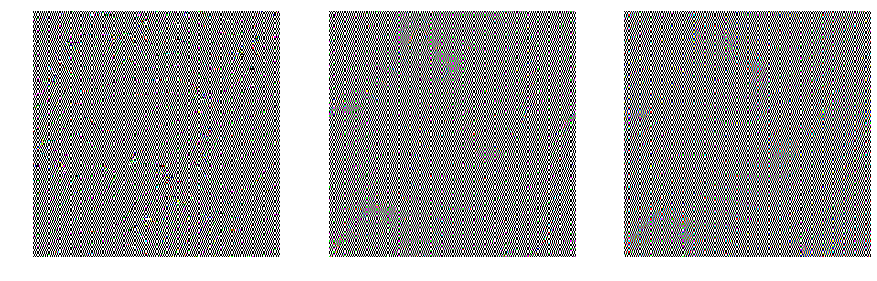

In [51]:
# for MobileNet
mob_pat = patterns[0][14]
p1, p2 = new_dft_patterns(mob_pat)
draw_imgs(list(map(maps_img, [mob_pat, p1, p2])))

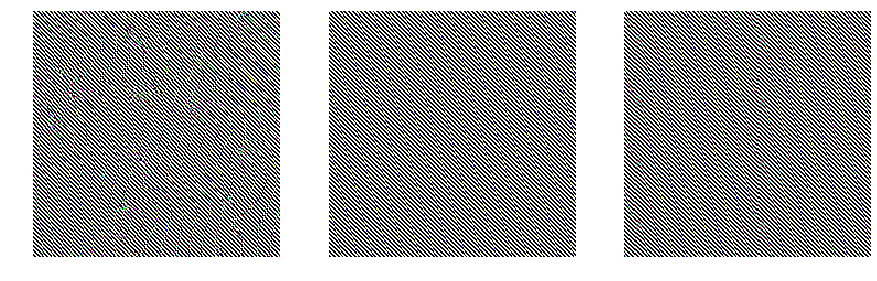

In [41]:
# for VGG
vgg_pat = patterns[1][14]
p1, p2 = new_dft_patterns(vgg_pat)
draw_imgs(list(map(maps_img, [vgg_pat, p1, p2])))

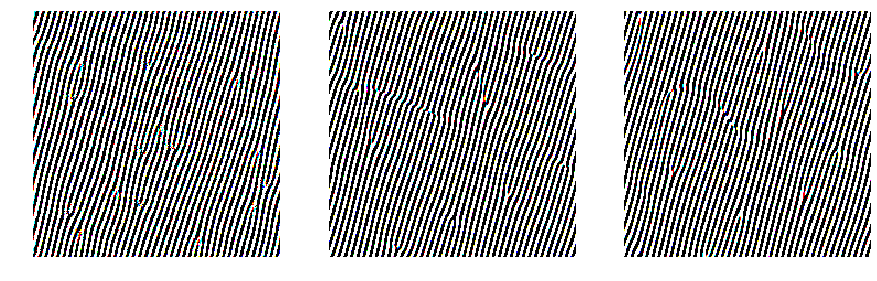

In [42]:
# for Inception
inc_pat = patterns[2][14]
p1, p2 = new_dft_patterns(inc_pat)
draw_imgs(list(map(maps_img, [inc_pat, p1, p2])))

## Draw pattern examples

In [23]:
def generate_patterns_noinit(kernel_files, img_size, n_per_kernel=3, 
                             separate_channels=False, kernel_type='2D'):
    patterns = []
    for kernel_file in kernel_files:
        # load pattern kernel
        if kernel_type == 'pointwise':
            kernel = np.load(kernel_file[0])
            pointwise = np.load(kernel_file[1])
        else:
            kernel = np.load(kernel_file)
            pointwise = None
        
        # generate several patterns
        for i in range(n_per_kernel):
            pattern = generate_pattern(img_size, conv_kernel=kernel, separate_channels=separate_channels, 
                                        kernel_type=kernel_type, pointwise_kernel=pointwise)
            patterns.append(pattern)
    return patterns

#### With initialization

In [55]:
pattern_files = [f'{npy_prefix}/turing_filter_pattern_mobilenet_91_500.npy', 
                 f'{npy_prefix}/turing_filter_pattern_vgg_75_500.npy', 
                 f'{npy_prefix}/turing_filter_pattern_inception_55_500.npy', 
                ]
patterns = [np.load(pattern_file) for pattern_file in pattern_files]

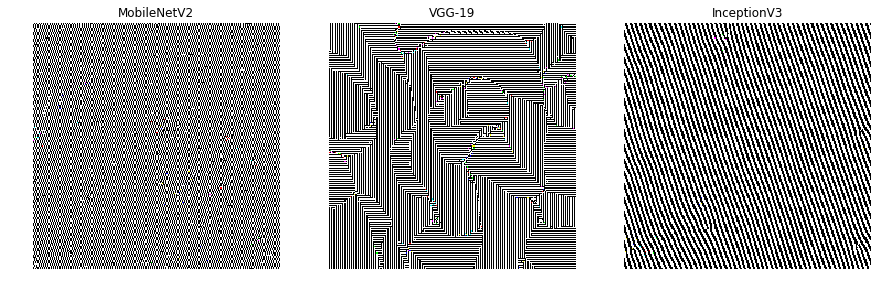

In [61]:
draw_imgs(list(map(maps_img, patterns)), labels=model_names, width=3)

#### No init, summation mixing

In [24]:
kernel_files = [f'{npy_prefix}/turing_filter_noinit_kernel_mobilenet_94_500.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_vgg_77_500.npy', 
                f'{npy_prefix}/turing_filter_noinit_kernel_inception_53_500.npy',]

patterns = generate_patterns_noinit(kernel_files, img_size)

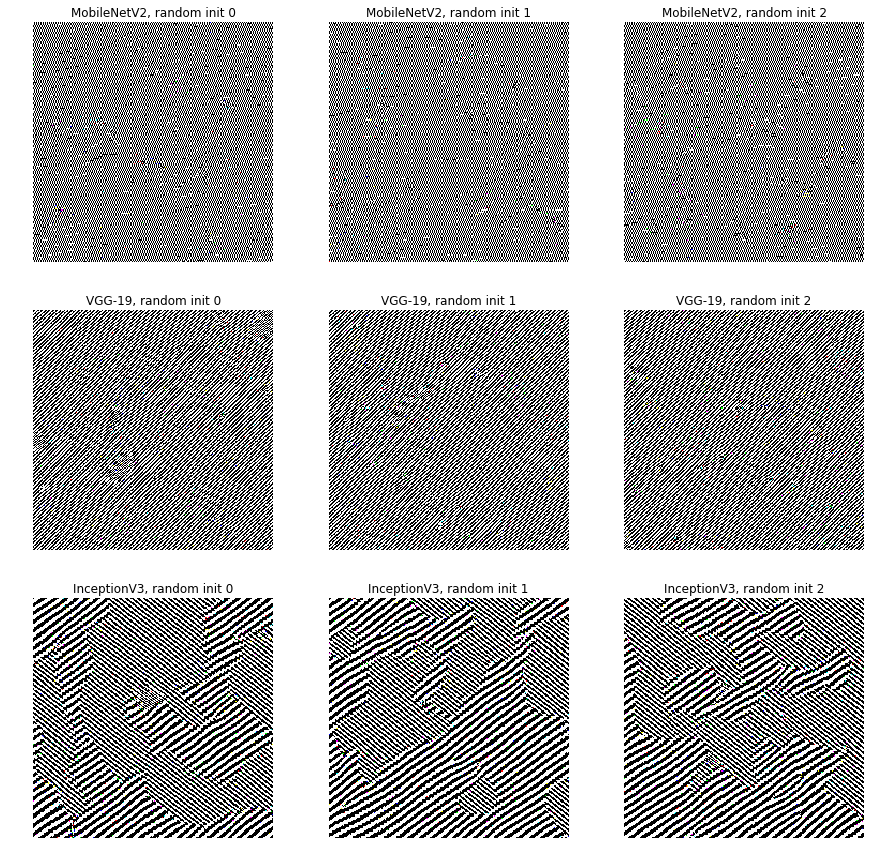

In [25]:
pattern_names = [f"{model_name}, random init {i}" for model_name in model_names for i in range(3)]
draw_imgs(list(map(maps_img, patterns)), labels=pattern_names, width=3)

#### No init, poinwise mixing patterns

In [53]:
kernel_files = [(f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_mobilenet_94_p_500.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_vgg_77_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_vgg_77_p_500.npy'), 
                (f'{npy_prefix}/turing_filter_noinit_pw_inception_53_500.npy', f'{npy_prefix}/turing_filter_noinit_pw_inception_53_p_500.npy'),
                ]

patterns = generate_patterns_noinit(kernel_files, img_size,
                                    separate_channels=True, kernel_type='pointwise')

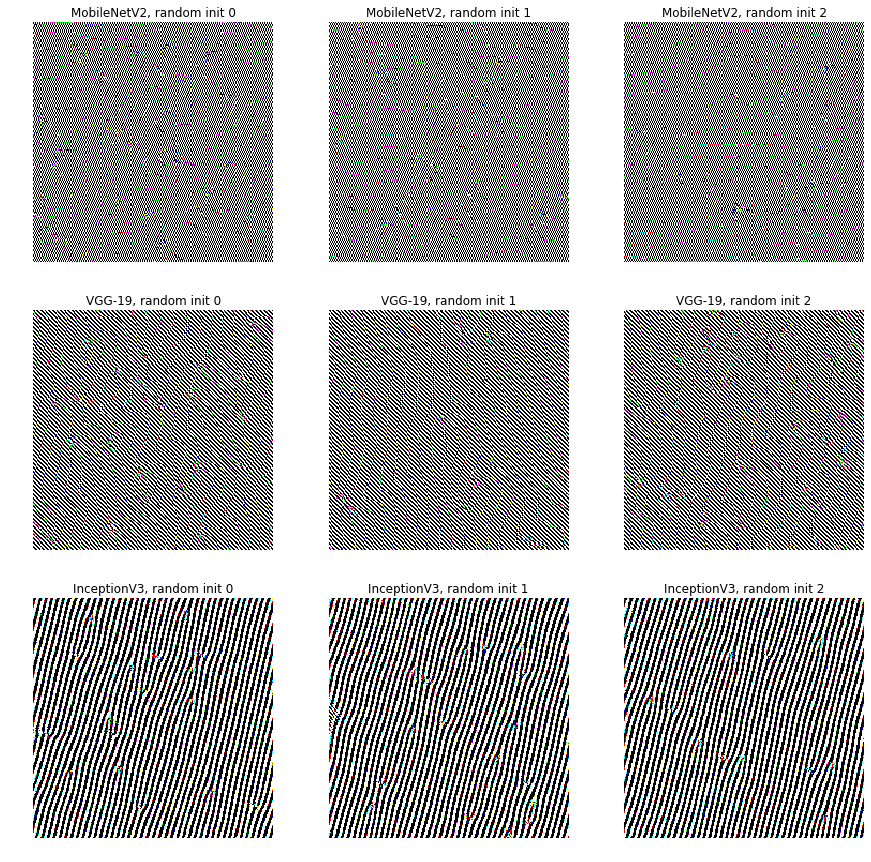

In [54]:
pattern_names = [f"{model_name}, random init {i}" for model_name in model_names for i in range(3)]
draw_imgs(list(map(maps_img, patterns)), labels=pattern_names, width=3)